<a href="https://colab.research.google.com/github/RautRitesh/langgraph/blob/main/Advanced_agent_with_decision_making.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

from typing import TypedDict, Sequence, Annotated
from langchain_core.prompts import PromptTemplate
from langchain_community.vectorstores import FAISS
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_huggingface import HuggingFaceEmbeddings
from langchain_groq import ChatGroq
from pydantic import BaseModel, Field
from langchain_core.output_parsers import PydanticOutputParser
from langchain_community.document_loaders import WebBaseLoader
from langgraph.graph import StateGraph,END

In [ ]:
from dotenv import load_dotenv

In [ ]:
import os

In [ ]:
llm=ChatGroq(model="openai/gpt-oss-20b",api_key=os.getenv("API_KEY"))
embedding=HuggingFaceEmbeddings(model="sentence-transformers/all-MiniLM-L6-v2")

In [ ]:
from langchain_community.document_loaders import PDFPlumberLoader
loader=PDFPlumberLoader("/content/Unit 5 Machine Learning (3).pdf")
docs=loader.load()

In [ ]:
print(docs)

[Document(metadata={'source': '/content/Unit 5 Machine Learning (3).pdf', 'file_path': '/content/Unit 5 Machine Learning (3).pdf', 'page': 0, 'total_pages': 54, 'Title': 'Diapositiva 1', 'Author': 'Mariajose', 'CreationDate': 'D:20210526060715', 'ModDate': 'D:20210526060715', 'Producer': 'Microsoft® Office PowerPoint® 2007', 'Creator': 'Microsoft® Office PowerPoint® 2007'}, page_content='Artificial Intelligence (CSIT 4th Sem)\nUnit:5 Machine Learning\n1\nPrepared By : Narayan Dhamala\n'), Document(metadata={'source': '/content/Unit 5 Machine Learning (3).pdf', 'file_path': '/content/Unit 5 Machine Learning (3).pdf', 'page': 1, 'total_pages': 54, 'Title': 'Diapositiva 1', 'Author': 'Mariajose', 'CreationDate': 'D:20210526060715', 'ModDate': 'D:20210526060715', 'Producer': 'Microsoft® Office PowerPoint® 2007', 'Creator': 'Microsoft® Office PowerPoint® 2007'}, page_content='Introduction to Machine Learning\n\uf0d8 Machine learning is the study of computer system that learn from\ndata and 

In [ ]:
text_splitter=RecursiveCharacterTextSplitter(chunk_size=1000,chunk_overlap=200)
chunk=text_splitter.split_documents(docs)

In [ ]:
vector_store=FAISS.from_documents(chunk,embedding)
retriever=vector_store.as_retriever(search_kwargs={"k":4})

In [ ]:
answer=retriever.invoke("what is machine learning")
print(answer)

[Document(id='ca6369cb-7126-45d3-98ba-d35aa819861d', metadata={'source': '/content/Unit 5 Machine Learning (3).pdf', 'file_path': '/content/Unit 5 Machine Learning (3).pdf', 'page': 1, 'total_pages': 54, 'Title': 'Diapositiva 1', 'Author': 'Mariajose', 'CreationDate': 'D:20210526060715', 'ModDate': 'D:20210526060715', 'Producer': 'Microsoft® Office PowerPoint® 2007', 'Creator': 'Microsoft® Office PowerPoint® 2007'}, page_content='Introduction to Machine Learning\n\uf0d8 Machine learning is the study of computer system that learn from\ndata and experience.\n\uf0d8 Machine learning is subfield of artificial intelligence which gives\nthe computer ability to learn without being explicitly programmed.\n\uf0d8 The goal of machine learning is to build computer system that\ncan adapt and learn from their experience.\n\uf0d8 A computer program is said to be learn if it‟s performance P\nimproves over a task T with an experience E.\n2\nPrepared By : Narayan Dhamala'), Document(id='d50a1780-b1f3-4

In [ ]:
from langchain_core.messages import BaseMessage
import operator

In [ ]:
class AgentState(TypedDict):
  messages:Annotated[Sequence[BaseMessage],operator.add]

In [ ]:
class TopicParser(BaseModel):
  Topic:str=Field(json_schema_extra="Topic selected")
  Reasoning:str=Field(json_schema_extra="Reason for selecting that topic")

In [ ]:
parser=PydanticOutputParser(pydantic_object=TopicParser)

In [ ]:
template="""Based on the user query determine the Topic related to the query. Topics are ['Machine Learning','Not Related].If the query is related to the Machine
Learning than choose Topic as MachineLearning else choose Not Related and also give the reason behind choosing it.You are not allowed to add any response simply choose the Topic and give the Reasoning for it. Do not add anything to the user question?
The user query is:{question}
{format_instructions}"""

In [ ]:
def function1(state):
  message=state["messages"]
  question=message[-1]
  print(question)
  prompt=PromptTemplate(template=template,
                        input_varaibles=[question],
                        partial_varaibles={
                            "format_instructions":parser.get_format_instructions()
                        })
  chain=prompt|llm|parser
  result=chain.invoke({"question":question,"format_instructions":parser.get_format_instructions()})
  return {"messages":[result.Topic]}

In [ ]:
function1({"messages":["Explain about Machines"]})

Explain about Machines


{'messages': ['Not Related']}

In [ ]:
def router(state):
  message=state["messages"]
  last_message=message[-1]
  print(last_message)
  if 'Machine Learning' not in last_message:
    return "LLM Call"
  else:
    return "RAG Call"


In [ ]:
router({"messages":['Machine Learning','Not Related']})

Not Related


'LLM Call'

In [ ]:
from langchain_core.output_parsers import StrOutputParser
from langchain_core.runnables import RunnablePassthrough

In [ ]:
template_1="""Generate the based answer on the basis of this context:{context}
for the question:{question}"""
prompt_rag=PromptTemplate.from_template(template_1)

In [ ]:
def function2(state):
  message=state["messages"]
  query=message[0]
  print(query)
  rag_chain=({"context":retriever, "question":RunnablePassthrough()}|prompt_rag|llm|StrOutputParser())
  result=rag_chain.invoke(query)
  return {"messages":[result]}

In [ ]:
def function3(state):
  message=state["messages"]
  query=message[0]
  complete_query=f"You are an expert answer giver , give the best  and short answer to the question based on your knowledge , question is:{query}"
  result=llm.invoke(complete_query)
  return({"messages":[result.content]})

In [ ]:
function3({"messages":["what is Machine Learning?"]})

{'messages': ['Machine learning is a field of artificial intelligence that builds algorithms allowing computers to automatically improve their performance on a task by learning patterns from data, rather than being explicitly programmed for every possible scenario.']}

In [ ]:
workflow=StateGraph(AgentState)
workflow.add_node("agent",function1)
workflow.add_node("RAG",function2)
workflow.add_node("LLM",function3)
workflow.set_entry_point("agent")
workflow.add_conditional_edges(
    "agent",
    router,
    {
        "LLM Call":"LLM",
        "RAG Call":"RAG",
    }
)
workflow.add_edge("RAG",END)
workflow.add_edge("LLM",END)
app=workflow.compile()


In [ ]:
from IPython.display import Image,display

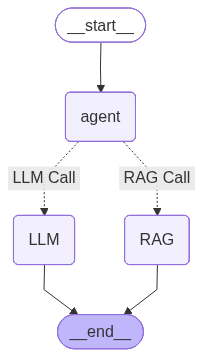

In [ ]:
try:
  display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
  print(e)

In [ ]:
output=app.invoke({"messages":["Explain the importance of Nepal in World?"]})


Explain the importance of Nepal in World?
Not Related


In [ ]:
output

{'messages': ['Explain the importance of Nepal in World?',
  'Not Related',
  'Ne\u202fpal’s importance to the world lies in its unique blend of geography, culture and strategic position:\n\n- **Geopolitical bridge** – It sits between India and China, acting as a natural buffer and a corridor for trade and diplomatic dialogue in South‑East and Central Asia.  \n- **Himalayan hub** – Home to Mount\u202fEverest and the world’s most iconic trekking routes, Nepal fuels a global tourism industry that supports millions of jobs worldwide.  \n- **Biodiversity & climate** – Its varied ecosystems—from alpine glaciers to tropical forests—are critical for water‑cycle regulation, wildlife conservation, and climate‑change research, offering data that benefit global environmental policy.  \n- **Cultural crossroads** – With a rich tapestry of Hindu, Buddhist, and indigenous traditions, Nepal preserves UNESCO‑listed heritage sites and serves as a living laboratory for peaceful cultural coexistence and s

In [ ]:
response=output["messages"][-1]
print(response)

Ne pal’s importance to the world lies in its unique blend of geography, culture and strategic position:

- **Geopolitical bridge** – It sits between India and China, acting as a natural buffer and a corridor for trade and diplomatic dialogue in South‑East and Central Asia.  
- **Himalayan hub** – Home to Mount Everest and the world’s most iconic trekking routes, Nepal fuels a global tourism industry that supports millions of jobs worldwide.  
- **Biodiversity & climate** – Its varied ecosystems—from alpine glaciers to tropical forests—are critical for water‑cycle regulation, wildlife conservation, and climate‑change research, offering data that benefit global environmental policy.  
- **Cultural crossroads** – With a rich tapestry of Hindu, Buddhist, and indigenous traditions, Nepal preserves UNESCO‑listed heritage sites and serves as a living laboratory for peaceful cultural coexistence and sustainable development.

Together, these factors make Nepal a key player in regional stability

In [ ]:
output=app.invoke({"messages":["What are the types of Learning in Machine Learning?"]})

What are the types of Learning in Machine Learning?
MachineLearning


In [ ]:
response=output["messages"][-1]
print(response)

**Types of learning in machine learning**

| Type | What it uses | Typical goal |
|------|--------------|--------------|
| **Supervised learning** | Labeled data (input + target) | Predict or classify new inputs |
| **Unsupervised learning** | Unlabeled data | Discover patterns, clusters, or representations |
| **Semi‑supervised learning** | Mostly unlabeled data + a few labels | Leverage both to improve accuracy |
| **Reinforcement learning** | Interaction with an environment (states, actions, rewards) | Learn a policy that maximizes cumulative reward |
| **Self‑supervised / contrastive learning** | Uses data itself to create pseudo‑labels | Learn useful representations without explicit labels |
| **Online / incremental learning** | Data arrives sequentially | Update model on the fly without retraining from scratch |
| **Transfer / meta‑learning** | Knowledge from one task/domain applied to another | Accelerate learning on new tasks |

These categories capture the main ways models lea

In [ ]:
for ouput in app.stream({"messages":["What are the types of Learning in Machine Learning?"]}):
  for k,v in output.items():
    print(f"From node :{k}")
    print("-------")
    print(v)
    print("\n---\n")

What are the types of Learning in Machine Learning?
MachineLearning
From node :messages
-------
['What are the types of Learning in Machine Learning?', 'MachineLearning', '**Types of learning in machine learning**\n\n| Type | What it uses | Typical goal |\n|------|--------------|--------------|\n| **Supervised learning** | Labeled data (input\u202f+\u202ftarget) | Predict or classify new inputs |\n| **Unsupervised learning** | Unlabeled data | Discover patterns, clusters, or representations |\n| **Semi‑supervised learning** | Mostly unlabeled data + a few labels | Leverage both to improve accuracy |\n| **Reinforcement learning** | Interaction with an environment (states, actions, rewards) | Learn a policy that maximizes cumulative reward |\n| **Self‑supervised / contrastive learning** | Uses data itself to create pseudo‑labels | Learn useful representations without explicit labels |\n| **Online / incremental learning** | Data arrives sequentially | Update model on the fly without retra